In [34]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.merge import concatenate
from keras import optimizers
import keras.backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import matplotlib
import pylab
from keras import metrics
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import train_test_split

In [40]:
cd

/Users/hanglou


# Prepare model input and ouput 

In [3]:
OrderbookDay1=pd.read_csv('Desktop/Project 4 - High Frequency Trading/LOBSTERCodeDemoMatlab/orderbook10.csv',header=None).values.astype(float)
OrderbookDay1[:,0::2]=(OrderbookDay1[:,0::2]/1e4)

In [9]:
def import_orderbook(OrderDir,MsgDir):
    orderbook=pd.read_csv(OrderDir,header=None).values.astype(float)
    message=pd.read_csv(MsgDir,header=None).values[:,:6] ##extract first 6 columb
    ##put the ask and bid price to zero at where there is no ask/bid order
    orderbook[np.where(orderbook==9999999999.0)]=0
    orderbook[np.where(orderbook==-9999999999.0)]=0
    orderbook=orderbook[:,:40]
    orderbook[:,0::2]=(orderbook[:,0::2]/1e4) # we normalize the price of the order book by dividing a factor 10000.
    #filter the orderbook data outside the market opening& closing time
    orderbook=orderbook[np.where((message[:,0]>=34200)&(message[:,0]<=57600)),:]
    orderbook=orderbook.reshape(orderbook.shape[1:])
    return(orderbook)
  

In [30]:
def price_move(mid):
    n=len(mid)
    Y=np.zeros([n,1])
    Y[0,0]=2
    for i in range(n-1):
        if mid[i+1]>mid[i]:
            Y[i+1,0]=0
        elif mid[i+1]==mid[i]:
            Y[i+1,0]=2
        else:
            Y[i+1,0]=1
    return(Y)

In [31]:
def delet_nopricemove(midprice):
    pricemove=price_move(midprice)

    index,=np.where(pricemove[:,0]==2)
    print('index where no next price move = {}'.format(index))
    pricemove1=np.delete(pricemove,index,0)
    print(pricemove1.shape)
    return(pricemove1,index)

In [38]:
def data_preparation(Order,pricemove,p):
    labels = keras.utils.to_categorical(pricemove, num_classes=2)
    dataX=InputData(Order,p)
    dataY=labels[p:,]
    X_train, X_ValTest, y_train, y_ValTest = train_test_split( dataX, dataY, test_size=0.2, shuffle = False)
    X_valid,X_test,y_valid, y_test= train_test_split(X_ValTest,y_ValTest,test_size=0.5,shuffle=False)
    X_train_scaled, X_test_scaled = Normalize3D_tensor_Data(X_train, X_test)
    X_train_scaled, X_valid_scaled = Normalize3D_tensor_Data(X_train, X_valid)
    return(X_train_scaled,X_valid_scaled,X_test_scaled,y_train,y_valid,y_test)

In [ ]:
def data_preparation1(Order,pricemove,p):
    labels = keras.utils.to_categorical(pricemove, num_classes=2)
    dataX=InputData(Order,p)
    dataY=labels[(p+1):,]
    X_train, X_ValTest, y_train, y_ValTest = train_test_split( dataX, dataY, test_size=0.2, shuffle = False)
    X_valid,X_test,y_valid, y_test= train_test_split(X_ValTest,y_ValTest,test_size=0.5,shuffle=False)
    X_train_scaled, X_test_scaled = Normalize3D_tensor_Data(X_train, X_test)
    X_train_scaled, X_valid_scaled = Normalize3D_tensor_Data(X_train, X_valid)
    return(X_train_scaled,X_valid_scaled,X_test_scaled,y_train,y_valid,y_test)

In [49]:
def save_to_2dtxt(localdir,data):
    with open(localdir, 'w') as outfile:
        for slice_2d in data:
            np.savetxt(outfile, slice_2d)

In [10]:
AMZN1=import_orderbook('Desktop/Project 4 - High Frequency Trading/LOBSTERCodeDemoMatlab/orderbook10.csv',
                       'Desktop/Project 4 - High Frequency Trading/LOBSTERCodeDemoMatlab/message10.csv')
AMZN2=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-22_24900000_57900000_orderbook_50.csv',
                      'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-22_24900000_57900000_message_50.csv')
AMZN3=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-25_24900000_57900000_orderbook_50.csv',
                      'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-25_24900000_57900000_message_50.csv')
AMZN4=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-26_24900000_57900000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-26_24900000_57900000_message_50.csv')
AMZN5=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-27_24900000_57900000_orderbook_50.csv',
                      'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-27_24900000_57900000_message_50.csv')
AMZN6=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-28_24900000_57900000_orderbook_50.csv',
                      'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-28_24900000_57900000_message_50.csv')
AMZN7=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-29_24900000_57900000_orderbook_50.csv',
                      'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AMZN_2012-06-22_2012-06-30_50/AMZN_2012-06-29_24900000_57900000_message_50.csv')
AMZN_7Days=np.concatenate((AMZN1,AMZN2,AMZN3,AMZN4,AMZN5,AMZN6,AMZN7))

In [25]:
AMZN_midprice=(AMZN_7Days[:,0]+AMZN_7Days[:,2])/2

In [26]:
AMZN_midprice.shape

(2205715,)

In [32]:
AMZN_pricemove,index=delet_nopricemove(AMZN_midprice)

index where no next price move = [      0       2       3 ... 2205712 2205713 2205714]
(189934, 1)


In [33]:
AMZN_order=np.delete(AMZN_7Days,index,0)
AMZN_order.shape

(189934, 40)

In [44]:
AMZN_x_train_scaled,AMZN_x_valid_scaled,AMZN_x_test_scaled,AMZN_y_train,AMZN_y_valid,AMZN_y_test=data_preparation(AMZN_order,AMZN_pricemove,50)

(151907, 50, 40)
(151907, 50, 40)


In [45]:
with open('Desktop/Project 4 - High Frequency Trading/Amazondata/AMZN_X_train.txt', 'w') as outfile:
    for slice_2d in AMZN_x_train_scaled:
        np.savetxt(outfile, slice_2d)


In [50]:
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/Amazondata/AMZN_x_train.txt',AMZN_x_train_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/Amazondata/AMZN_x_valid.txt',AMZN_x_valid_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/Amazondata/AMZN_x_test.txt',AMZN_x_test_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/Amazondata/AMZN_y_train.txt',AMZN_y_train)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/Amazondata/AMZN_y_valid.txt',AMZN_y_valid)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/Amazondata/AMZN_y_test.txt',AMZN_y_test)

In [46]:
new_data = np.loadtxt('Desktop/Project 4 - High Frequency Trading/Amazondata/AMZN_X_train.txt')
new_data=new_data.reshape(AMZN_x_train_scaled.shape)
assert np.all(new_data == AMZN_x_train_scaled)

AAPL data

In [51]:
AAPL1=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-22_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-22_34200000_57600000_message_50.csv')
AAPL2=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-25_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-25_34200000_57600000_message_50.csv')
AAPL3=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-26_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-26_34200000_57600000_message_50.csv')
AAPL4=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-27_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-27_34200000_57600000_message_50.csv')
AAPL5=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-28_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-28_34200000_57600000_message_50.csv')
AAPL6=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-29_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-29_34200000_57600000_message_50.csv')
AAPL_6Days=np.concatenate((AAPL1,AAPL2,AAPL3,AAPL4,AAPL5,AAPL6))


In [53]:
AAPL_midprice=(AAPL_6Days[:,0]+AAPL_6Days[:,2])/2
AAPL_pricemove,index=delet_nopricemove(AAPL_midprice)
AAPL_order=np.delete(AAPL_6Days,index,0)
AAPL_order.shape

index where no next price move = [      0       1       3 ... 2339065 2339066 2339067]
(300735, 1)


(300735, 40)

In [54]:
AAPL_x_train_scaled,AAPL_x_valid_scaled,AAPL_x_test_scaled,AAPL_y_train,AAPL_y_valid,AAPL_y_test=data_preparation(AAPL_order,AAPL_pricemove,50)


(240548, 50, 40)
(240548, 50, 40)


In [55]:
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_x_train.txt',AAPL_x_train_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_x_valid.txt',AAPL_x_valid_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_x_test.txt',AAPL_x_test_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_y_train.txt',AAPL_y_train)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_y_valid.txt',AAPL_y_valid)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_y_test.txt',AAPL_y_test)

FARO data

In [ ]:
FARO1=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-22_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-22_34200000_57600000_message_50.csv')
FARO2=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-25_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-25_34200000_57600000_message_50.csv')
FARO3=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-26_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-26_34200000_57600000_message_50.csv')
FARO4=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-27_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-27_34200000_57600000_message_50.csv')
FARO5=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-28_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-28_34200000_57600000_message_50.csv')
FARO6=import_orderbook('Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-29_34200000_57600000_orderbook_50.csv',
                       'Desktop/Project 4 - High Frequency Trading/_data_dwn_32_231__AAPL_2012-06-22_2012-06-30_50/AAPL_2012-06-29_34200000_57600000_message_50.csv')
FARO_6Days=np.concatenate((FARO1,FARO2,FARO3,FARO4,FARO5,FARO6))


In [ ]:
FARO_midprice=(FARO_6Days[:,0]+FARO_6Days[:,2])/2
FARO_pricemove,index=delet_nopricemove(FARO_midprice)
FARO_order=np.delete(FARO_7Days,index,0)
FARO_order.shape

In [ ]:
FARO_x_train_scaled,FARO_x_valid_scaled,FARO_x_test_scaled,FARO_y_train,FARO_y_valid,FARO_y_test=data_preparation(FARO_order,FARO_pricemove,50)


In [ ]:
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_x_train.txt',AAPL_x_train_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_x_valid.txt',AAPL_x_valid_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_x_test.txt',AAPL_x_test_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_y_train.txt',AAPL_y_train)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_y_valid.txt',AAPL_y_valid)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPL_y_test.txt',AAPL_y_test)

# Data contains the signatures gathering information at no pricemove timestep


In [71]:
def OrderSig_NoPricemove2d(UpdatedOrder,OriginalOrder,midprice,d=4):
    Y=price_move(midprice)
    index1,=np.where(Y[:,0]!=2)

    print('index where price moves = {}'.format(index1))

    n=UpdatedOrder.shape[0]

    dim=ts.logsigdim(2,d)
    OrderSig=np.zeros([n-1,2*dim+UpdatedOrder.shape[1]])

    for i in range(n-1):
        length=index1[i+1]+1-index1[i]
        ask_seq=OriginalOrder[index1[i]:index1[i+1]+1,0:2]
        bid_seq=OriginalOrder[index1[i]:index1[i+1]+1,2:4]
        ask_sig,ask_logsig=DataToSignature1(ask_seq.reshape(1,length,2),d)
        bid_sig,bid_logsig=DataToSignature1(bid_seq.reshape(1,length,2),d)
        OrderSig[i,:]=np.concatenate((OriginalOrder[i+1,:].reshape(1,40),np.concatenate((ask_logsig,bid_logsig),1)),axis=1)
    return(OrderSig)

In [58]:
def data_preparation1(Order,pricemove,p):
    labels = keras.utils.to_categorical(pricemove, num_classes=2)
    dataX=InputData(Order,p)
    dataY=labels[(p+1):,]
    X_train, X_ValTest, y_train, y_ValTest = train_test_split( dataX, dataY, test_size=0.2, shuffle = False)
    X_valid,X_test,y_valid, y_test= train_test_split(X_ValTest,y_ValTest,test_size=0.5,shuffle=False)
    X_train_scaled, X_test_scaled = Normalize3D_tensor_Data(X_train, X_test)
    X_train_scaled, X_valid_scaled = Normalize3D_tensor_Data(X_train, X_valid)
    return(X_train_scaled,X_valid_scaled,X_test_scaled,y_train,y_valid,y_test)

In [73]:
AAPLOrderSig=OrderSig_NoPricemove2d(AAPL_order,AAPL_6Days,AAPL_midprice,d=4)

index where price moves = [      2       7       9 ... 2339049 2339057 2339058]


In [76]:
AAPLsig2d_x_train_scaled,AAPLsig2d_x_valid_scaled,AAPLsig2d_x_test_scaled,AAPLsig2d_y_train,AAPLsig2d_y_valid,AAPLsig2d_y_test=data_preparation1(AAPLOrderSig,AAPL_pricemove,50)


(240547, 50, 56)
(240547, 50, 56)


In [77]:
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPLsig2d_x_train.txt',AAPLsig2d_x_train_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPLsig2d_x_valid.txt',AAPLsig2d_x_valid_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPLsig2d_x_test.txt',AAPLsig2d_x_test_scaled)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPLsig2d_y_train.txt',AAPLsig2d_y_train)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPLsig2d_y_valid.txt',AAPLsig2d_y_valid)
save_to_2dtxt('Desktop/Project 4 - High Frequency Trading/AAPLdata/AAPLsig2d_y_test.txt',AAPLsig2d_y_test)

In [ ]:
def OrderSig_NoPricemove4d(UpdatedOrder,OriginalOrder,midprice,d=4):
    Y=price_move(midprice)
    index1,=np.where(Y[:,0]!=2)

    print('index where price moves = {}'.format(index1))

    n=UpdatedOrder.shape[0]

    dim=ts.logsigdim(4,d)
    OrderSig=np.zeros([n-1,dim+UpdatedOrder.shape[1]])

    for i in range(n-1):
        length=index1[i+1]+1-index1[i]
        BidAskSeq=OriginalOrder[index1[i]:index1[i+1]+1,:4]
        BidAsk_sig,BidAsk_logsig=DataToSignature1(BidAskSeq.reshape(1,length,4),d)

        OrderSig[i,:]=np.concatenate((OriginalOrder[i+1,:].reshape(1,40),BidAsk_logsig),axis=1)
    return(OrderSig)

In [ ]:
dataY1=OutputData(labels,50)
print(dataY1.shape)
print(dataX.shape)

In [ ]:
from sklearn.model_selection import train_test_split
# It is import to set the shuffle flag to be False, as we would like to use the first 90% of data for the training and the rest for testing. 
# The default flag of train_test_split is True, in which case the testing data is randomly selected from the whole data.

X_train, X_ValTest, y_train, y_ValTest = train_test_split( dataX, dataY, test_size=0.2, shuffle = False)
X_valid,X_test,y_valid, y_test= train_test_split(X_ValTest,y_ValTest,test_size=0.5,shuffle=False)

In [ ]:
#X_train_scaled, X_valid_scaled = Normalize3D_tensor_Data(X_train, X_valid)
X_train_scaled, X_test_scaled = Normalize3D_tensor_Data(X_train, X_test)
X_train_scaled, X_valid_scaled = Normalize3D_tensor_Data(X_train, X_valid)
#print(X_train_scaled)

# Functions

In [14]:
def InputData(X,p):
    n=X.shape[0]
    Y=np.zeros([n-p,p,X.shape[1]])
    for i in range(n-p):
        Y[i,:,:]=X[i:(i+p),:]
    return(Y)
def OutputData(X,P):
    n=X.shape[0]
    Y=np.zeros([n-p,p,X.shape[1]])
    for i in range(n-p):
        Y[i,:,:]=X[i+1:(i+p+1),:]
    return(Y)
def InputData1(X,p,sub_interval):
    n=X.shape[0]
    Y=np.zeros([int((n-p)/sub_interval),int(p/sub_interval),X.shape[1]])
    for i in range(int((n-p)/sub_interval)):
        Y[i,:,:]=X[i*sub_interval:(i*sub_interval+p):sub_interval,:]
    return(Y)

In [15]:
from sklearn import preprocessing

def Normalize3D_tensor_Data(X_train, X_test):
    dim_train = np.shape(X_train)
    print(dim_train)
    X_train_scaled = np.zeros(np.shape(X_train), dtype = float)
    X_test_scaled = np.zeros(np.shape(X_test), dtype = float)
    for i in range(dim_train[1]):
       #for j in range(dim_train[2]):
        scaler = preprocessing.StandardScaler().fit(X_train[:, i, :])
        X_train_scaled[:, i, :] = scaler.transform(X_train[:, i, :])  
        X_test_scaled[:, i, :] = scaler.transform(X_test[:, i, :])  
    return X_train_scaled, X_test_scaled

In [16]:
def lstm0(nodes,p1,inputsize,rec_dropout,dropout):
    model=Sequential()
    model.add(LSTM(nodes,recurrent_dropout=rec_dropout,dropout=dropout,input_shape=(p1,inputsize),))
    #model.add(LSTM(nodes,return_sequences=True,recurrent_dropout=rec_dropout,dropout=dropout))
    #model.add(LSTM(nodes,recurrent_dropout=rec_dropout,dropout=dropout))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(2,activation='softmax'))
    adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=[metrics.categorical_accuracy])
    return(model)

In [17]:
def lstm1(nodes,p1,inputsize,rec_dropout,dropout):
    model=Sequential()
    model.add(LSTM(nodes,return_sequences=True,recurrent_dropout=rec_dropout,dropout=dropout,input_shape=(p1,inputsize),))
    model.add(LSTM(nodes,return_sequences=True,recurrent_dropout=rec_dropout,dropout=dropout))
    model.add(LSTM(nodes,recurrent_dropout=rec_dropout,dropout=dropout))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2,activation='softmax'))
    adam=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=[metrics.categorical_accuracy])
    return(model)

In [18]:
def lstm2(nodes,p1,inputsize,rec_dropout,dropout):
    model=Sequential()
    model.add(LSTM(nodes,return_sequences=True,recurrent_dropout=rec_dropout,dropout=dropout,input_shape=(p1,inputsize),))
    #model.add(LSTM(nodes,return_sequences=True,recurrent_dropout=rec_dropout,dropout=dropout))
    #model.add(LSTM(nodes,return_sequences=True,recurrent_dropout=rec_dropout,dropout=dropout))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2,activation='softmax'))
    adam=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=[metrics.categorical_accuracy])
    return(model)

In [19]:
def DataToSignature1(data,d):
    sigdim=ts.sigdim(data.shape[2],d) #length of the signature with degree d
    logsigdim=ts.logsigdim(data.shape[2], d) #length of the logsignature with degree d
    sigX=np.zeros([data.shape[0],sigdim])
    logsigX=np.zeros([data.shape[0],logsigdim])
    for i in range(data.shape[0]):
        sigX[i,:]=ts.stream2sig(data[i,:,:],d)
        logsigX[i,:]=ts.stream2logsig(data[i,:,:],d)
    return(sigX,logsigX)  
    

In [20]:
def DatatoSignature2(data,d):
    sigdim=ts.sigdim(2,d)
    logsigdim=ts.logsigdim(2,d)
    sigX=np.zeros([data.shape[0],10*sigdim])
    logsigX=np.zeros([data.shape[0],10*logsigdim])
    for i in range(data.shape[0]):
        for j in range(10):
            sigX[i,j*sigdim:(j+1)*sigdim]=ts.stream2sig(data[i,:,j:j+2],d)
            logsigX[i,j*logsigdim:(j+1)*logsigdim]=ts.stream2logsig(data[i,:,j:j+2],d)
    return(sigX,logsigX)

# Signature

In [62]:
!pip install esig

You are using pip version 18.0, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [63]:
import esig as esig
import esig.tests as tests
tests.run_tests()
import esig.tosig as ts
#help(ts)
import numpy as np


T = 10
d = 2
path = np.zeros((T, d), float) # d-dimensional time series of length T
for i in range(T):
    path[i, 0] = np.sin(i)
    path[i, 1] = np.cos(i)

print('path is ')
print(path)


sig_deg = 2 # degree of the siganture
dim = ts.sigdim(d, sig_deg ) # the signature dimension
siganture_feature = ts.stream2sig(path, sig_deg)
print('signature feature set')
print(siganture_feature)

.......

path is 
[[ 0.          1.        ]
 [ 0.84147098  0.54030231]
 [ 0.90929743 -0.41614684]
 [ 0.14112001 -0.9899925 ]
 [-0.7568025  -0.65364362]
 [-0.95892427  0.28366219]
 [-0.2794155   0.96017029]
 [ 0.6569866   0.75390225]
 [ 0.98935825 -0.14550003]
 [ 0.41211849 -0.91113026]]
signature feature set
[ 1.          0.41211849 -1.91113026  0.08492082 -3.97436624  3.18675413
  1.82620944]



----------------------------------------------------------------------
Ran 7 tests in 0.060s

OK


#  3 Layers LSTM followed by a softmax, Crossentropy loss. Only use original orderbook data, duplicate the model in recent paper.

In [25]:
labels = keras.utils.to_categorical(Y1, num_classes=2)

In [26]:
labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [27]:
p=50
dataX=InputData(orderbook1,50)
dataY=labels[50:,]
print(dataY.shape)

(189884, 2)


In [28]:
dataY1=OutputData(labels,50)
print(dataY1.shape)
print(dataX.shape)

(189884, 50, 2)
(189884, 50, 40)


In [36]:
from sklearn.model_selection import train_test_split
# It is import to set the shuffle flag to be False, as we would like to use the first 90% of data for the training and the rest for testing. 
# The default flag of train_test_split is True, in which case the testing data is randomly selected from the whole data.

X_train, X_ValTest, y_train, y_ValTest = train_test_split( dataX, dataY, test_size=0.2, shuffle = False)
X_valid,X_test,y_valid, y_test= train_test_split(X_ValTest,y_ValTest,test_size=0.5,shuffle=False)

In [37]:
#X_train_scaled, X_valid_scaled = Normalize3D_tensor_Data(X_train, X_valid)
X_train_scaled, X_test_scaled = Normalize3D_tensor_Data(X_train, X_test)
X_train_scaled, X_valid_scaled = Normalize3D_tensor_Data(X_train, X_valid)
#print(X_train_scaled)

(151907, 50, 40)
(151907, 50, 40)


In [34]:
#model1=lstm0(30,50,40,0.2,0.2)
model1 = load_model('best_model1.h5')

In [38]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint(filepath='best_model1.h5', monitor='val_loss', save_best_only=True)]
hist1=model1.fit(X_train_scaled, y_train,validation_data=(X_valid_scaled,y_valid),callbacks=callbacks,batch_size=200, epochs=30, shuffle=False,verbose=1)
model1 = load_model('best_model1.h5')
scores1 = model1.evaluate(X_test_scaled, y_test, verbose=1)
print(scores1)

Train on 151907 samples, validate on 18988 samples
Epoch 1/30
151907/151907 [==============================] - 65s 428us/step - loss: 0.6572 - categorical_accuracy: 0.5982 - val_loss: 0.6756 - val_categorical_accuracy: 0.5777
Epoch 2/30
151907/151907 [==============================] - 51s 336us/step - loss: 0.6576 - categorical_accuracy: 0.5980 - val_loss: 0.6752 - val_categorical_accuracy: 0.5794
Epoch 3/30
151907/151907 [==============================] - 52s 343us/step - loss: 0.6573 - categorical_accuracy: 0.5984 - val_loss: 0.6749 - val_categorical_accuracy: 0.5819
Epoch 4/30
151907/151907 [==============================] - 52s 340us/step - loss: 0.6567 - categorical_accuracy: 0.6000 - val_loss: 0.6746 - val_categorical_accuracy: 0.5831
Epoch 5/30
151907/151907 [==============================] - 52s 345us/step - loss: 0.6566 - categorical_accuracy: 0.6001 - val_loss: 0.6745 - val_categorical_accuracy: 0.5819
Epoch 6/30
151907/151907 [==============================] - 52s 344us/step

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


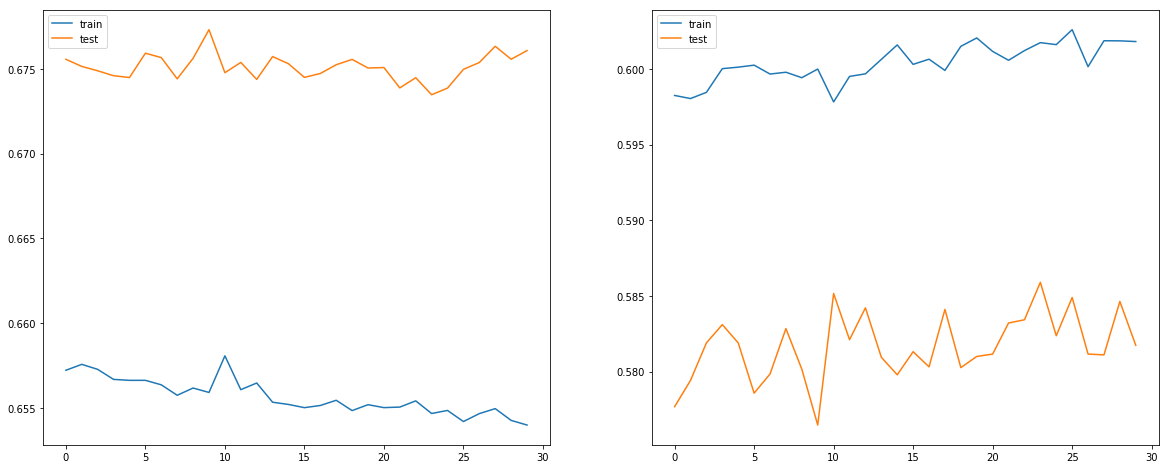

In [39]:
print(hist1.history.keys())

def plot_hist(hist):
    plt.figure(figsize = (20, 8))
    plt.subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.legend(['train','test'])
    plt.subplot(122)
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.legend(['train','test'])
  
plot_hist(hist1)

# Use Signature to summary the information where there is no price change# 

In [29]:
index1,=np.where(Y[:,0]!=2)

print('index where price moves = {}'.format(index1))

d=4
n=orderbook1.shape[0]

dim=ts.logsigdim(2,d)
UpdatedOrderbook=np.zeros([n-1,2*dim+orderbook1.shape[1]])

for i in range(n-1):
    length=index1[i+1]+1-index1[i]
    ask_seq=np.concatenate((Orderbook_7days[index1[i]:index1[i+1]+1,0].reshape(length,1),Orderbook_7days[index1[i]:index1[i+1]+1,1].reshape(length,1)),1)
    bid_seq=np.concatenate((Orderbook_7days[index1[i]:index1[i+1]+1,2].reshape(length,1),Orderbook_7days[index1[i]:index1[i+1]+1,3].reshape(length,1)),1)
    ask_sig,ask_logsig=DataToSignature1(ask_seq.reshape(1,length,2),d)
    bid_sig,bid_logsig=DataToSignature1(bid_seq.reshape(1,length,2),d)
    UpdatedOrderbook[i,:]=np.concatenate((Orderbook_7days[i+1,:].reshape(1,40),np.concatenate((ask_logsig,bid_logsig),1)),axis=1)  

index where price moves = [      1      32      44 ... 2205704 2205705 2205706]


In [30]:
UpdatedX=InputData(UpdatedOrderbook,50)
UpdatedY=labels[51:,]
print(UpdatedX.shape)
print(UpdatedY.shape)

(189883, 50, 56)
(189883, 2)


In [32]:
from sklearn.model_selection import train_test_split
UpdatedX_train,UpdatedX_test, UpdatedY_train, UpdatedY_test = train_test_split( UpdatedX, UpdatedY ,test_size=0.2, shuffle = False)
UpdatedX_valid,UpdatedX_test, UpdatedY_valid, UpdatedY_test = train_test_split( UpdatedX_test, UpdatedY_test ,test_size=0.5, shuffle = False)


In [40]:
UpdatedX_train_scaled, UpdatedX_test_scaled = Normalize3D_tensor_Data(UpdatedX_train,UpdatedX_test)

UpdatedX_train_scaled, UpdatedX_valid_scaled = Normalize3D_tensor_Data(UpdatedX_train,UpdatedX_valid)

(151906, 50, 56)
(151906, 50, 56)


In [41]:
FullDataLstm1=lstm0(100,50,56,0.1,0.1)

In [42]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10), ModelCheckpoint(filepath='best_model_Fulllstm.h5', monitor='val_loss', save_best_only=True)]
hist_FullData1=FullDataLstm1.fit(UpdatedX_train_scaled, UpdatedY_train,callbacks=callbacks,validation_data=(UpdatedX_valid_scaled,UpdatedY_valid),batch_size=1000, epochs=100, shuffle=False,verbose=1)
FullDataLstm1= load_model('best_model_Fulllstm.h5')
FullDatascores1 = FullDataLstm1.evaluate(UpdatedX_test_scaled  , UpdatedY_test, verbose=1)
print(FullDatascores1)

Train on 151906 samples, validate on 18988 samples
Epoch 1/100
151906/151906 [==============================] - 103s 679us/step - loss: 0.6945 - categorical_accuracy: 0.5177 - val_loss: 0.6931 - val_categorical_accuracy: 0.5156
Epoch 2/100
151906/151906 [==============================] - 75s 496us/step - loss: 0.6804 - categorical_accuracy: 0.5634 - val_loss: 0.6760 - val_categorical_accuracy: 0.5621
Epoch 3/100
151906/151906 [==============================] - 77s 504us/step - loss: 0.6627 - categorical_accuracy: 0.6073 - val_loss: 0.6669 - val_categorical_accuracy: 0.5855
Epoch 4/100
151906/151906 [==============================] - 77s 508us/step - loss: 0.6541 - categorical_accuracy: 0.6232 - val_loss: 0.6626 - val_categorical_accuracy: 0.5984
Epoch 5/100
151906/151906 [==============================] - 79s 520us/step - loss: 0.6501 - categorical_accuracy: 0.6272 - val_loss: 0.6596 - val_categorical_accuracy: 0.6055
Epoch 6/100
151906/151906 [==============================] - 75s 492

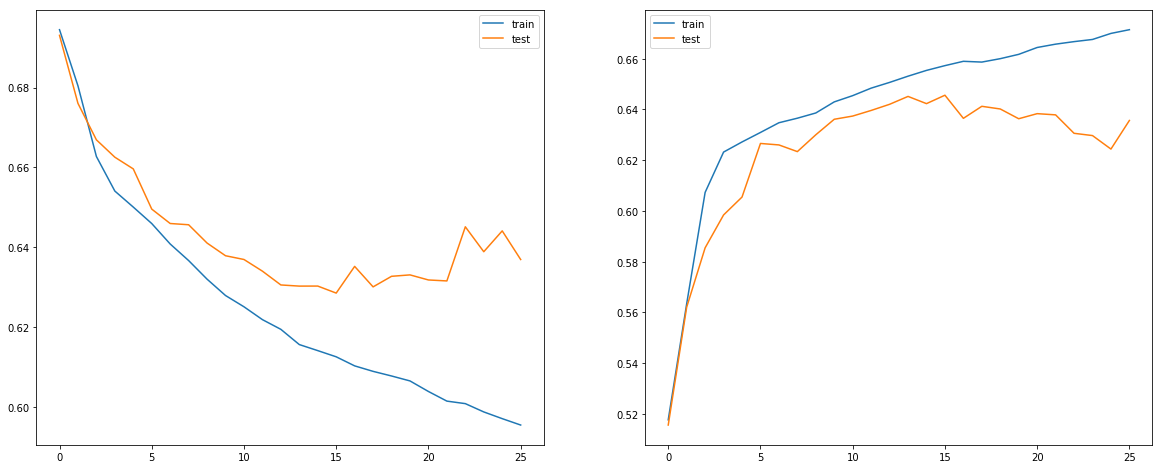

In [43]:
plot_hist(hist_FullData1)